# Pràctica 2: Aprenentatge No Supervisat

## 0. Introducció:

L'objectiu d'aquesta pràctica és aplicar i comparar diferents tècniques d'aprenentatge automàtic **no supervisat** sobre dos conjunts de dades proporcionats. 

**Tècniques a comparar**

- **Principal Component Analysis (PCA)**
- **t-distributed Stochastic Neighbor Embedding (t-SNE)**
- **k-means**
- **Agglomerative Hierarchical Clustering (AHC)**
- **Autoencoders**
- **Self-Organizing Maps (SOM)**

**Conjunts de Dades**

- `A2-synthetic.txt`:
  - **Variables**: 4 característiques numèriques
  - **Classe**: 1 (només per visualització)
  - **Nombre de patrons**: 360
  - **Comentari**: No s'utilitzarà la informació de la classe durant l'entrenament.

- `A2-real.txt`:
    - **Variables**: 5 característiques numèriques
    - **Informació addicional**: 1 localització i 1 classe (totes dues només per visualització)
    - **Nombre de patrons**: 333
    - **Comentari**: Tant la classe com la localització s'utilitzaran només per comparar els resultats en els plots.


S'han de visualitzar els resultats obtinguts, analitzar el comportament i l'eficiència de cada tècnica. I per últim, comparar els resultats amb les etiquetes reals (clase i localització), només a nivell de visualització.

## 1. Lectura de dades

Es carreguen els conjunts de dades proporcionats:
- **A2-synthetic.txt** conté 4 característiques (`x1, x2, x3, x4`) i una etiqueta classe.
- **A2-real.txt** conté 5 característiques ('BL, BD, FL, BM, S`), una localització i una classe.

En aquesta secció es carrega i es mostra una primero visió dels dos conjunts de dades per tal de comprovar el format i el contingut.

Apunt: Per instalar tensorflow s'ha utilitzat `!pip install tensorflow`, cosa que ens ha generat problemes de compatibilitat amb `numpy`. Per tant hem rebaixat la versió de `numpy` a la 1.23.5 amb `!pip install numpy==1.23.5`

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from minisom import MiniSom

2025-05-30 15:16:26.428709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 15:16:26.453153: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 15:16:26.538634: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 15:16:26.677653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748618186.800246    9812 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748618186.82

In [2]:
#Lectura de dades
df_synthetic = pd.read_csv('A2-synthetic.txt') # Separador = ','
df_real = pd.read_csv('A2-real.txt', sep=';') # Separador = ';'

print("Primeres files del conjunt A2-synthetic:")
display(df_synthetic.head())

print("\nPrimeres files del conjunt A2-real:")
display(df_real.head())

Primeres files del conjunt A2-synthetic:


,x1,x2,x3,x4,class
0,-0.031676,-9.912054,-0.579436,-1.044239,1
1,0.002526,6.172456,3.288339,-1.006427,5
2,0.183123,-0.387841,6.236470,-1.691491,2
3,-0.042262,-1.996272,-1.655302,-2.995311,1
4,-0.062811,-0.417072,6.657475,-3.633134,4



Primeres files del conjunt A2-real:


,BL,BD,FL,BM,S,Location,Class
0,34.5,18.1,187,2900,1,L2,C1
1,38.8,20.0,190,3950,0,L3,C1
2,45.1,14.5,207,5050,1,L2,C2
3,34.6,21.1,198,4400,0,L1,C1
4,40.6,19.0,199,4000,0,L1,C1


## 2. Pre-Processament

Segons l'enunciat, els conjunt de dades proporcionats ja han estat prèviament tractats per eliminar dades no físiques, outliers, i valors nuls o incomplets.

Per tant, no s'ha aplicat cap procés de neteja addicional. El pre-processament s'ha limitat a:

1. **Separació de les etiquetes** (`class`, `location`) per a ús exclusiu en la visualització.
2. **Normalització** de les variables mitjançant `StandardScaler, deixant totes les característiques amb mitjana 0 i desviació estàndard 1.

In [3]:
# (Sintètic) Extreure classe (només per visualització)
X_synthetic = df_synthetic.drop(columns=['class']).values
y_synthetic_class = df_synthetic['class'].values

# (REAL) Extreure classe i location (només per visualització
X_real = df_real.drop(columns=['Location', 'Class']).values
y_real_class = df_real['Class'].values
y_real_location = df_real['Location'].values

#Normalització
scaler = StandardScaler()

X_synthetic_scaled = scaler.fit_transform(X_synthetic)
X_real_scaled = scaler.fit_transform(X_real)

print("Conjunt Sintètic:")
print("\nMitjana:", np.mean(X_synthetic_scaled, axis=0))
print("\nDesviació estàndard:", np.std(X_synthetic_scaled, axis=0))


print("\nConjunt Real:")
print("\nMitjana:", np.mean(X_real_scaled, axis=0))
print("\nDesviació estàndard:", np.std(X_real_scaled, axis=0))

Conjunt Sintètic:

Mitjana: [ 0.00000000e+00 -4.93432455e-17 -3.94745964e-17  4.93432455e-18]

Desviació estàndard: [1. 1. 1. 1.]

Conjunt Real:

Mitjana: [ 3.52070725e-16  5.76115732e-16  1.76035362e-16 -8.00160738e-17
 -4.26752394e-17]

Desviació estàndard: [1. 1. 1. 1. 1.]


## 3. Tècniques d'aprenentatge no supervisat

### PCA (Principal Component Analysis)

PCA és una **tècnica d'anàlisis estadística** utilitzada per **reduir la dimensionalitat** d'un conjunt de dades mantenint la major part de la seva variabilitat. Transforma les variables originals en un nou conjunt de variables ortogonals anomenades components principals, ordenades segona la quantitat de **variància** que expliquen.

En aquest apartat es faran 2 anàlisis:

- **Projecció en dues dimensions**: Projecció de les dades en els dos primers components principals per tal de visualitzar les possibles agrupacions. Cada classe real es representarà amb un color diferent.
- **Gràfic de la variància acumulada**: Resprsentació de la variància acumulada en funció del nombre de components principals per veure quants són necessaris per explicar un percentatge elevat de la variabilitat de les dades.

In [4]:
# Funció per la projecció PCA en 2 dimensions
def plot_pca_2d(X, y, title):
    pca = PCA()
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='tab10', s=40)
    plt.title(f"{title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Classe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Funció per el "Scree plot"
def plot_scree(X, title):
    pca = PCA().fit(X)
    explained_var = pca.explained_variance_ratio_
    cum_var = explained_var.cumsum()

    plt.figure(figsize=(5, 4))
    plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', linestyle='--', color='b')
    plt.title(f'Scree Plot - Variància Acumulada - {title}')
    plt.xlabel('Número de components principals')
    plt.ylabel('Variància acumulada')
    plt.grid(True)
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% variància')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Dades Sintètiques

Es visualitza la projecció en 2D utilitzant la classe de cada patró com a color per facilitar la interpretació. També es mostra el scree plot per veure la variància acumulada explicada. 

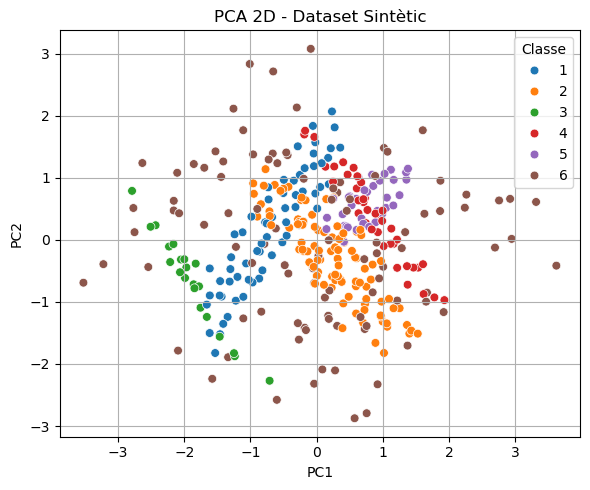

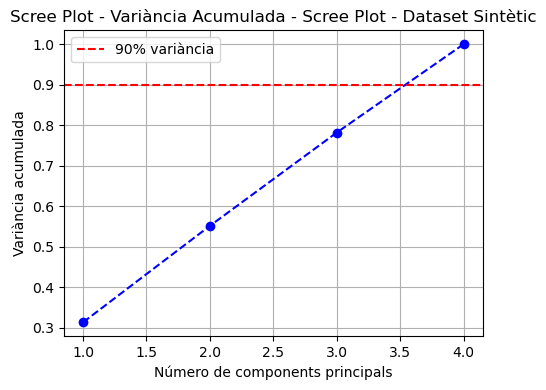

In [5]:
# Projecció PCA en 2 dimensions
plot_pca_2d(X_synthetic_scaled, y_synthetic_class, "PCA 2D - Dataset Sintètic")

# Scree Plot
plot_scree(X_synthetic_scaled, "Scree Plot - Dataset Sintètic")

#### Anàlisis Dades sintètiques

1. **Projecció PCA en 2 Dimensions**

A primera vista, es pot observar que les classes no estan completament separades en aquest espai de 2 dimensions. Hi ha una superposició considerable entre diverses classes. Això suggereix que els dos primer components principals, tot i capturar la major variabilitat, no són suficients per discriminar clarament totes les classes.

Es pot identificar que la Classe 3 (verd) sembla estar més aïllada respecte les altres classes.

Vient tanta superposició implica que un classificador basat en aquests dos components tindria dificultats per tenir una precisió alta i que potser requereixen més dimensions.

2. **Scree Plot Variància Acumulada**

- El primer component (PC1) explica aproximadament un 30% de variància
- El dos components (PC1 + PC2), s'explica el 55% de la variància acumulada. Això reforça la projecció en 2D vista anteriorment.
- Amb tres components (PC1 + PC2 + PC3) s'aconsegueix el 78% de la variància acumulada.
- I amb quatre components (PC1 + PC2 + PC3 + PC4) s'arriba al 100% de la variància acumulada.

En el gràfica la línea vermella discontinua es el 90% de variància per explicar el 90% de la variabilitat del dataset sintètic. Es veu que per arribar aquí, es necessiten quatre components principals.

**Conclusions**

El scree plot ens dona el context per entendre la visualització 2D de PCA. Ens avisa que reduir la dimensionalitat a només 2 components principals implica una pèrdua d'aproximadament el 45% de la variància). Això suggereix que la superposició de classes podria ser, en part, per aquesta reducció de dimensionalitat.

#### Dades reals

Es visualitza la projecció en 2D utilitzant la classe i la localització de cada patró com a color per facilitar la interpretació. També es mostra el scree plot per veure la variància acumulada explicada. 

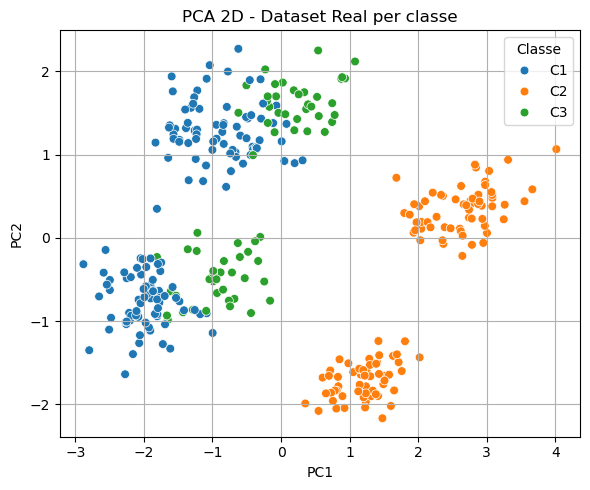

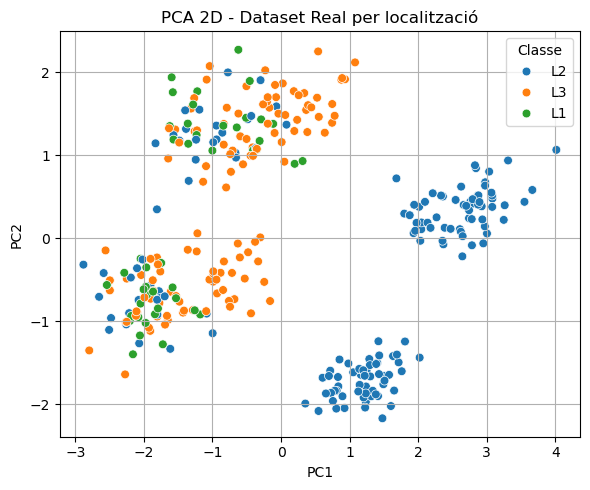

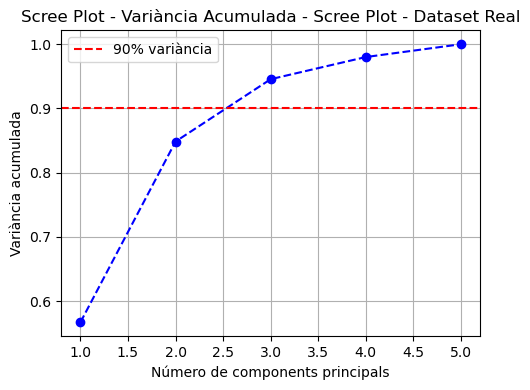

In [6]:
# Projecció PCA en 2 dimensions
plot_pca_2d(X_real_scaled, y_real_class, "PCA 2D - Dataset Real per classe")

# Projecció PCA en 2 dimensions
plot_pca_2d(X_real_scaled, y_real_location, "PCA 2D - Dataset Real per localització")

# Scree Plot
plot_scree(X_real_scaled, "Scree Plot - Dataset Real")

#### Anàlisis Dades Reals

1. **Projecció PCA en 2 Dimencions - Per Classe**

A diferència del dataset sintètic, aquí observem una separació més clara entre les classes. La Classe C2 (taronja) forma un clúster molt ben definit a la dreta del gràfic, i les classes C1 (blau) i C3 (verd) estan més barrejades en la part esquerra, però encara mostren tendència a formar clústers separats.

Aquesta reducció de dimensionalitat sembla capturar prou informació per discriminar les classes, almenys la C2 de les altres.

2. **Projecció PCA en 2 Dimencions - Per Localització**

La disposició dels punt és exactament la mateixa que a la gràfica per classe. Amb la única diferència que la Localització 1 (blau) es troba en tots els clústers diferenciats. Això ens permet veure que la localització i la classe tenen una estructura similar.

3. **Scree Plot - Variància Acumulada**

- El primer component (PC1) explica aproximadament el 57% de la variància total.
- Amb dos components (PC1 + PC2), s'explica el 85% de la variància acumulada.
- Amb tres components, s'arriba al 95% de la variància acumulada.
- Amb quatre components, s'assoleix el 98% de la variància
- I amb cinc components, s'explica el 100% de la variància.

El "colze" de la corba es pot observar clarament després de la segona component principal, ja que la pendent disminueix a partir de la tercera component. Per tant, segons el criteri del 90% de variància, 3 component seiren suficients per capturar la major part d'informació.


**Conclusions**

Els dos primers components principals (PC1 i PC2) ja són suficients per mostrar una clara separació entre classes, donant aproximadament un 85% de variància acumulada, cosa que no passava amb el sintètic. I també podem veure que hi ha una relació estreta entre les variables "Classe" i "Localització", ja que mostren patrons similars. 

En resum, l'anàlisis PCA en aquest dataset real és molt exitosa, confirmant que es pot aconseguir una reducció de dimensionalitat significativa.

### t-SNE

En aquesta secció s'aplica la tècnica de **t-distibuted Stochastic Neighbor Embedding (t-SNE)** per reduir la dimensionalitat de les dades a 2 dimensions. A diferència del PCA, és una tècnica **no lineal** que està especialment dissenyada per preservar les relacions de veïnatge. Transforma les distàncies entre punts d'un espai i intenta trobar una representació en un espai menorque preservi relacions de proximitat.

El paràmetre de **perplexity** controla l'equilibri entre estructura local i global** del mapa generat. Valors baixos donen més importància a la relació amb pocs veïns i valors altes capturen estructures més globals.

In [7]:
def plot_tsne_2d(X, y, title, perplexities=[5, 30, 50]):
    for perp in perplexities:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42, init='pca', learning_rate='auto')
        X_tsne = tsne.fit_transform(X)

        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10', s=40)
        plt.title(f't-SNE 2D - {title} (perplexity={perp})')
        plt.xlabel('Dimensió 1')
        plt.ylabel('Dimensió 2')
        plt.legend(title='Classe')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#### Dades sintètiques

Es mostren les projeccions 2D per diversos valors del paràmetre **perplexity**. Els punts es mostren amb colors diferents segons la seva **classe real**.

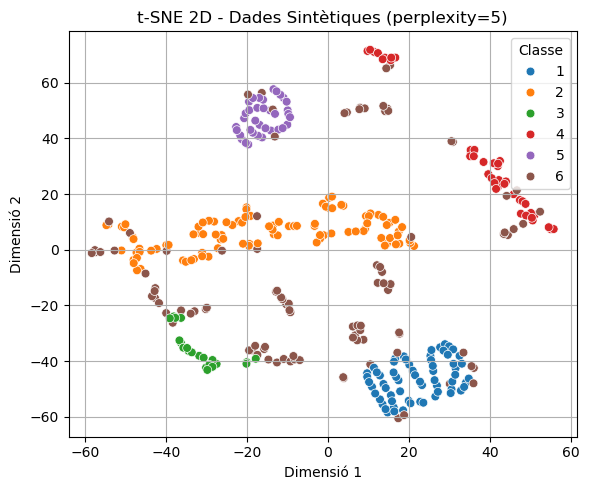

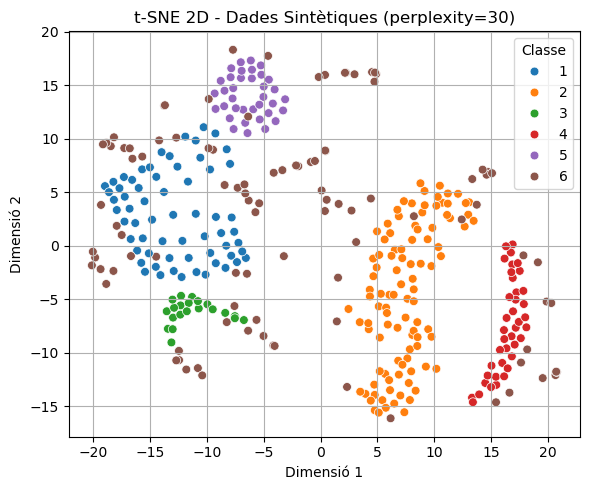

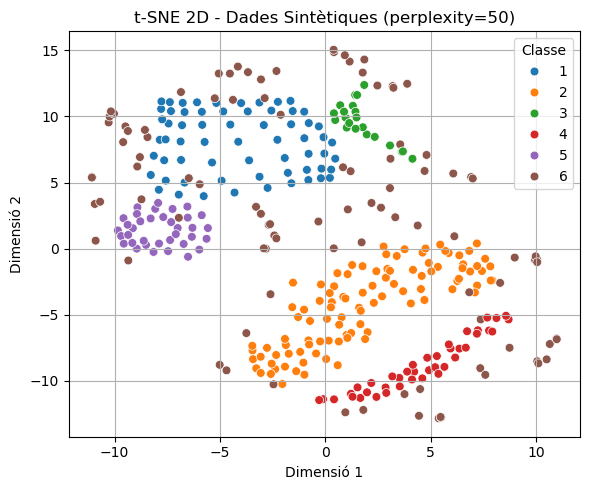

In [8]:
# t-SNE per a dades sintètiques
plot_tsne_2d(X_synthetic_scaled, y_synthetic_class, 'Dades Sintètiques', perplexities=[5,30,50])

#### Anàlisis Dataset Sintètic


- **Perplexity = 5**
  
S'observa que les classes estan representades com a clústers petits i fragmentats. Amb una perxplexity baixa, tendeix a posar èmfasis en les relacions de veïnatge més properes. Algunes classes com la Classe 1 (blau) i la Classe 6 (marró), estan molt disperses i fragmentades.

- **Perplexity = 30**

S'observa una millor cohesió dels clústers amb menys fragmentació. L'estructura es més clara i sembla més "netejada" i representativa dels possibles grups, reduient l'èmfasi en detalls locals excessius.

Es mostra un cert equilibri entre l'estructura local i global on la visualització proporciona una millor comprensió de les agrupacions del dataset sintètic.

- **Perplexity = 50**

Amb una perplexity alta comença a centrar-se en relacions de veïnatge més llunyanes, cosa que fa que els clústers es facin més dispersos. S'observa major solapament que amb un valor de perplexity 30, i canvis en la forma i la posició dels clústers. 

En conclusió:

- Perplexity 5: Molt fragmentat, difícil de veure l'estructura global
- Perplexity 30: Sembla ser el valor més òptim per a aquest dataset, ja que mostra clústers compactes i una millor separació de classes.
- Perplexity 50: Els clúster comencen a solapar-se més i a perdre una mica de la seva definició.

#### Dades reals

Es mostren les projeccions 2D per diversos valors del paràmetre **perplexity**. Els punts es mostren amb colors diferents segons la seva **classe real** i de la **localització**.

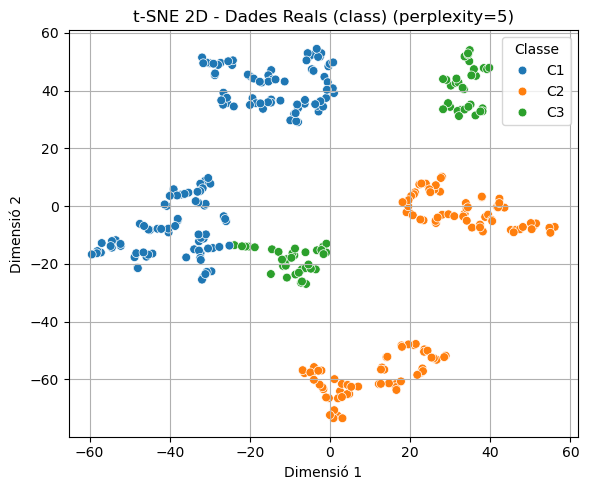

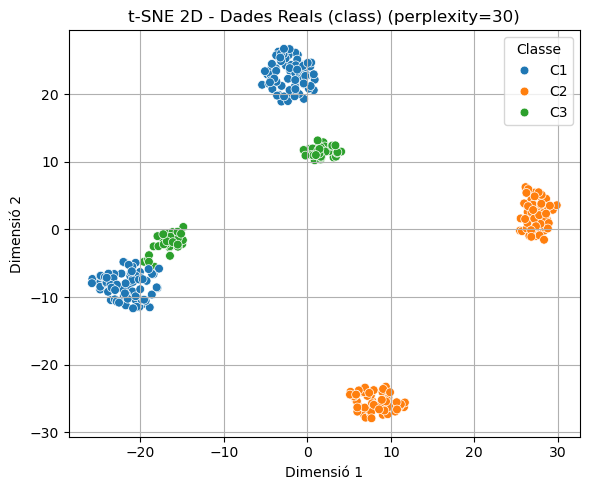

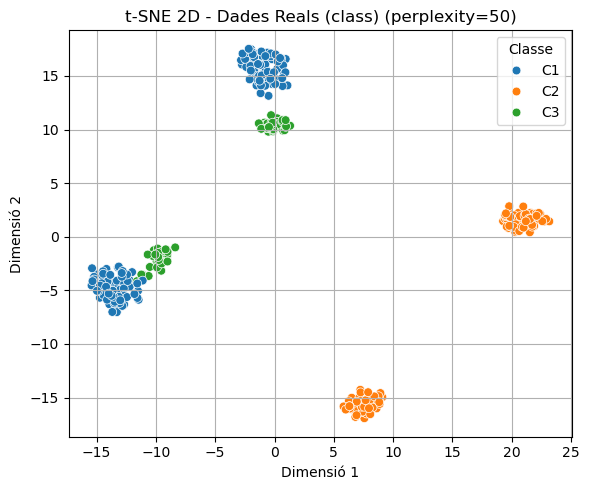

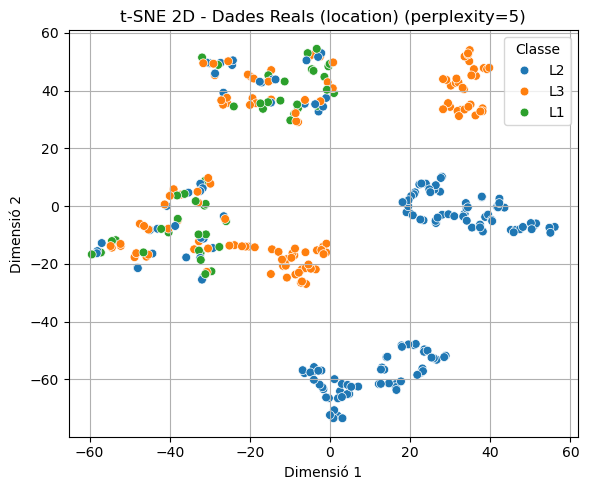

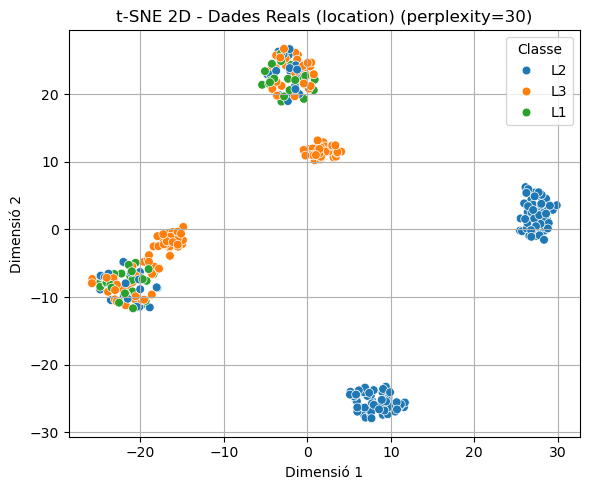

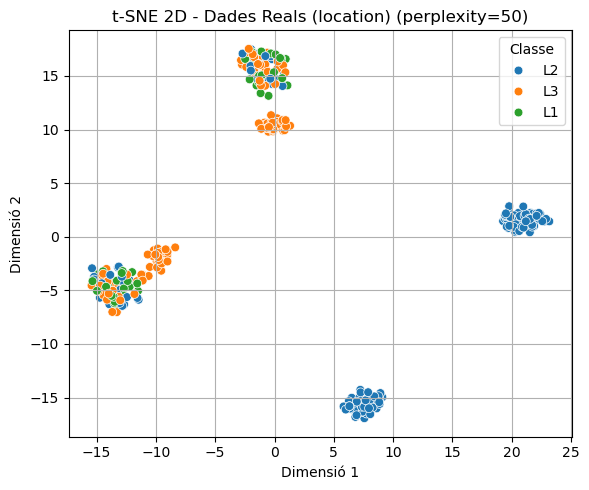

In [9]:
# t-SNE per a dades reals (class)
plot_tsne_2d(X_real_scaled, y_real_class, 'Dades Reals (class)', perplexities=[5, 30, 50])

# t-SNE per a dades reals (location)
plot_tsne_2d(X_real_scaled, y_real_location, 'Dades Reals (location)', perplexities=[5, 30, 50])

#### Anàlisis Dataset Real

**Per Classe**

- **Perplexity = 5**

Les classes mostren una tendència a formar clústers, però hi ha una fragmentació considerlable i s'observa que les Classes es divideixen en sub-clústers. La baixa perplexity genera una visualització amb molts detalls locals però amb una cohesió global pobre.

- **Perplexity = 30**

S'observa una millora significativa en la cohesió dels clústers, amb una separació gairebé perfecta. Les classes formen agrupacions més compactes i ben definides i es pot veure clarament 3 clústers diferenciats sense pràcticament solapament.

- **Perplexity = 50**

La visualització és similar a la de 30. Potser hi ha lleugeres diferències en la forma o densitat dels clústers, però la separació es manté excel·lent. 

Per aquest dataset, la perplexitat de 50 és la més adequada, ja que mostra un clara separació de les 3 classes en l'espai de 2 dimensions.

**Per Location**

Les observacions i conclusions per a les dades reals per localitzación són idèntiques a les dades reals per classe. Això reafirma l'observació ja feta a l'anàlisis de PCA: les variables "Classe i Localització" són pràcticament idèntiques.

La correspondència amb la Classe és que la Localització 2 correspon a la classe C1, C2. La Localització 3 a la Classe C3, C1 i la Localització 1 a la classe C1.

En resum, t-SNE es mostra com una eina efectiva, millor que la PCA, per visualitzar la separabilitat de les classes en el dataset real. El valor de 30-50 sembla ser el més adequat per a aquest propòsit.

### k-means

En aquesta secció s'utiliza l'algoritme **k-means** per agrupar els patrons en diferents clústers. K-Means és una tècnica d'aprenentatge no supervisat molt coneguda per la seva simplicitat i eficiència, especialment útil quan es desconeix el nombre de grups dins el conjunt de dades. Intenta minimitzar la distància intracluster, fa que els punt de cada clúster estiguin tan a prop com sigui del centre.

In [10]:
def kmean_clustering_and_plot(X, y_true, title, k_range):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        y_pred = kmeans.fit_predict(X)

        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette='tab10', s=40)
        plt.title(f'K-Means Clustering ({title}) - k={k}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### Dades sintètiques

Per cada valor de k (2-6), es mostra un **scatter plot** amb la projecció **PCA en 2 dimensions** dels patrons, on cada color representa un clúster trobat.

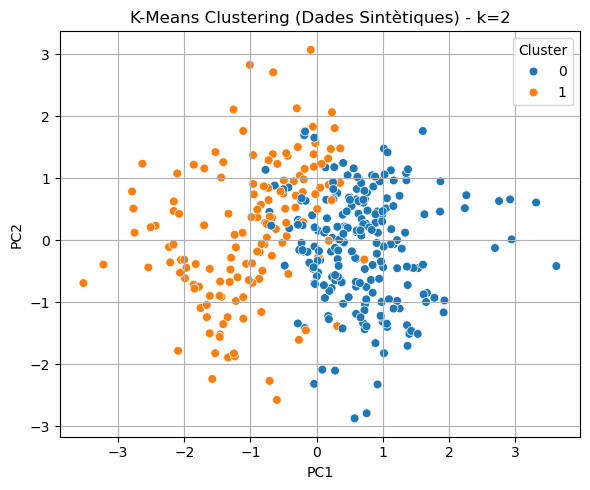

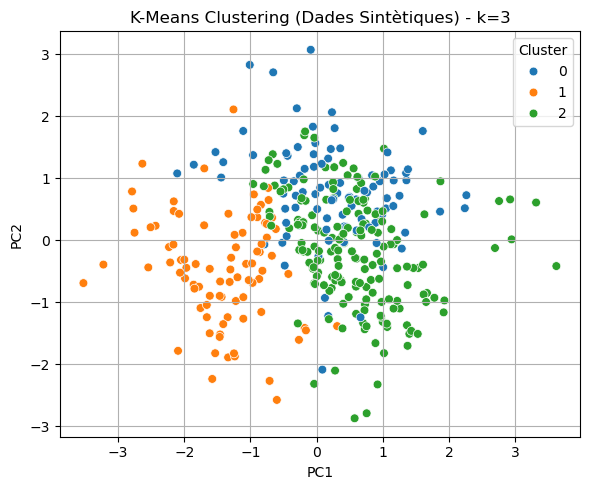

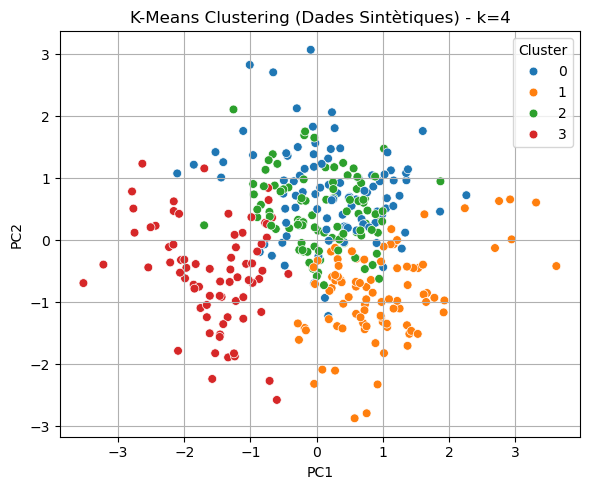

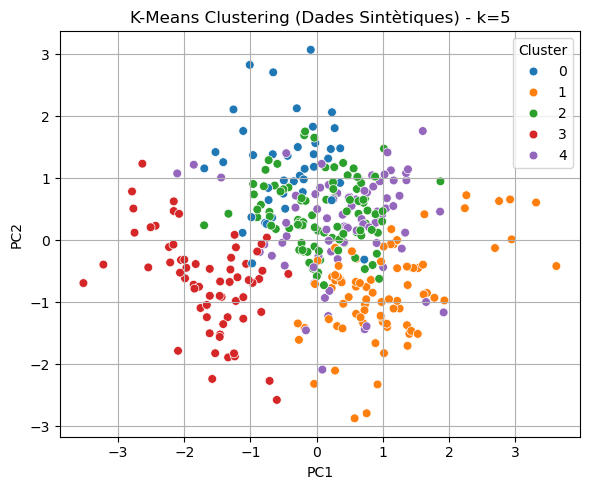

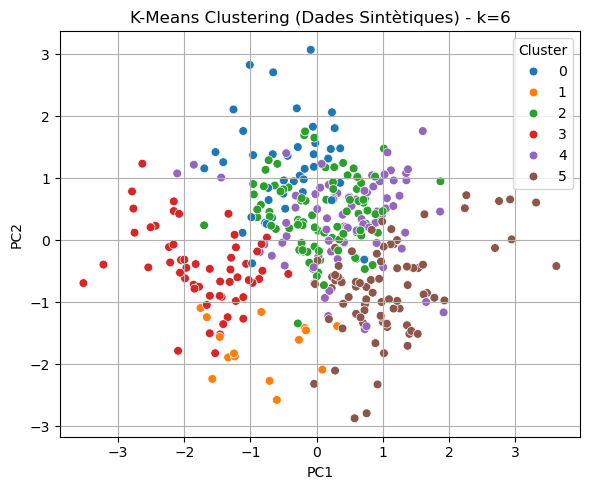

In [11]:
kmean_clustering_and_plot(X_synthetic_scaled, y_synthetic_class, 'Dades Sintètiques', k_range=range(2, 7))

#### Anàlisis Dades sintètiques

- **K-Means (k=2)**

Les dades es divideixen en dos grans clústers, un en la part esquerre i l'altre a la dreta. Hi ha un solpament significatiu entre el dos clústers a la zona central, cosa que és esperable observant el dataset sintètic anteriorment.

Aquesta divisió simple no reflecteix la complexitat de les dades sintètiques, que sabem que tenen 6 classes reals.

- **K-Means (k=3)**

S'observa una partició en 3 reagions on el solapament central segueix sent visible, especialment entre el clúster blau i verd.  

- **K-Means (k=4)**

S'intenta adaptar més a la distribució de les dades. La fragmentació que s'observava amb PCA per 6 classes es comença a abordar millor aquí, però la superposició indica que encara no s'ha trobat la quantitat òptima de clústers.

- **K-Means (k=5)**

Aquest s'acosta més a la complexitat de les dades sintètiques. Tendeix a formar agrupacions més petites i evidents, però la superposició limita la capacitat de k-means per separar perfectament aquestes classes reals amb només 2 components principals.

- **K-Means (k=6)**

Aquí el valor de k ja és el nombre real de classes, encara així k-means té dificultat per separar les classes ja que estàn superposades en l'espai de baixa dimensionalitat (PC1 i PC2). Els clúster continuen estant molt barrejats i no reflecteixen clarament les classes del dataset sintètic.

En conclusió, hi ha dificultat amb superposició quan projectem les dades en 2D. A mesura que augmenta la k, k-means crea clústers més petits però no millora dràsticament. Això dona importància a triar la tècnica de reducció de dimensionalitat i el nombre de clústers adequats.

#### Dades reals

Per cada valor de k (2-6), es mostra un **scatter plot** amb la projecció **PCA en 2 dimensions** dels patrons, on cada color representa un clúster trobat.

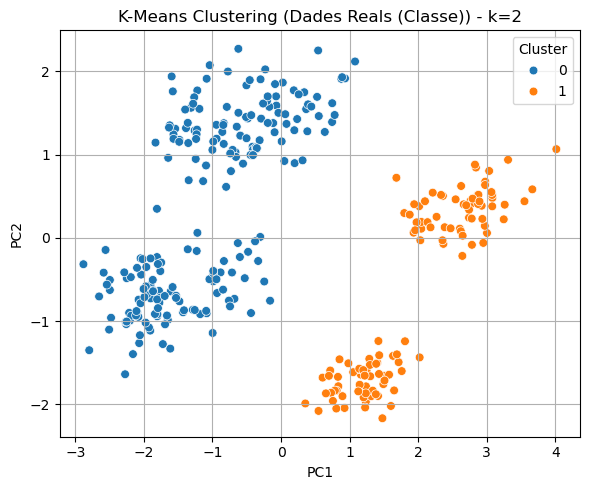

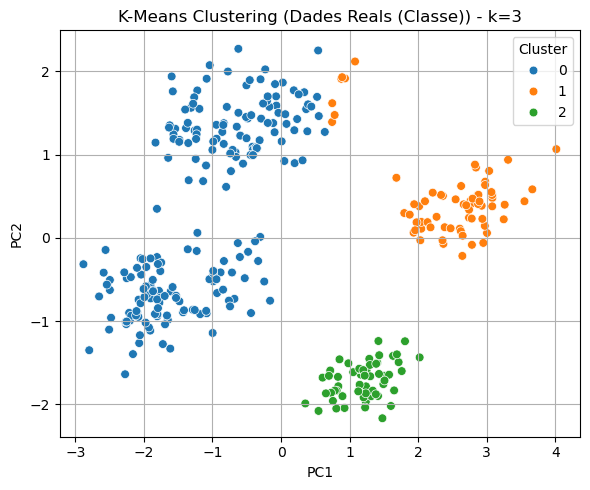

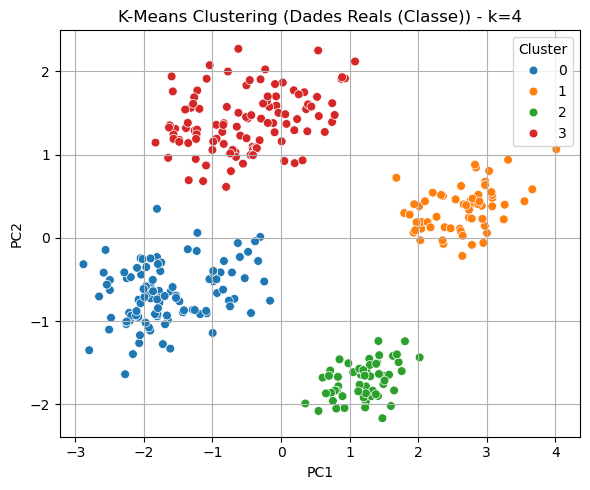

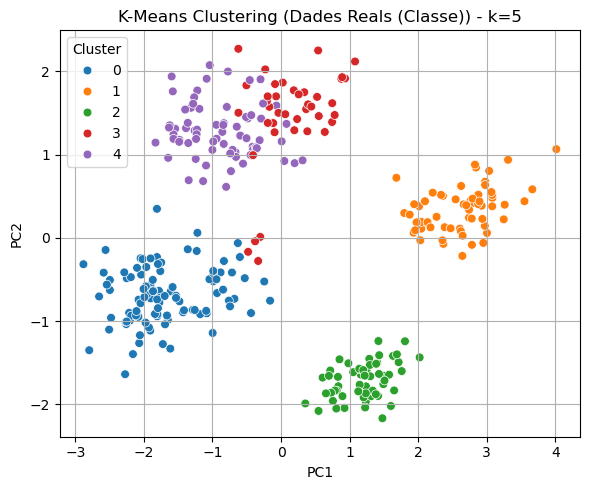

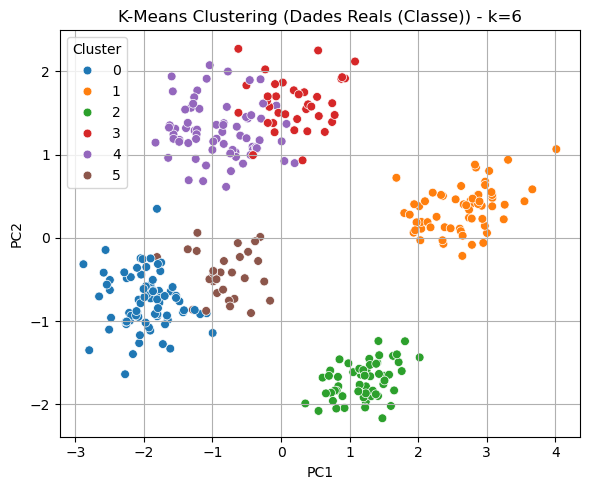

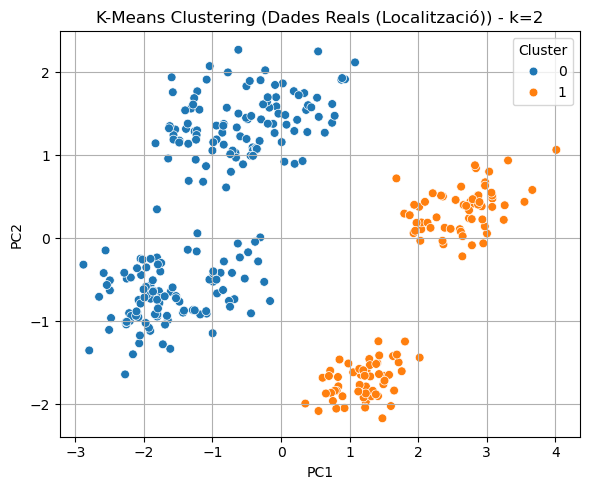

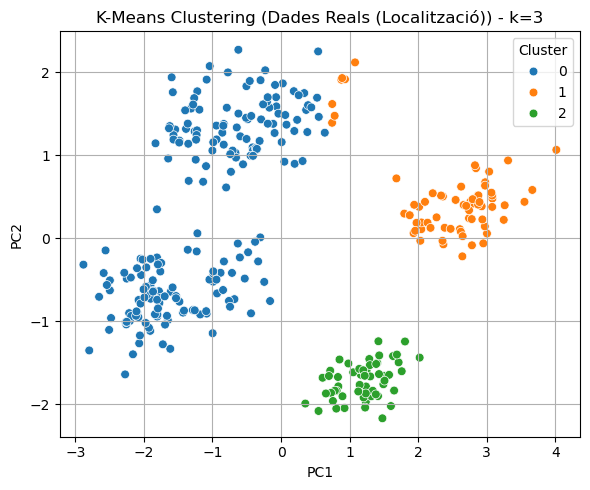

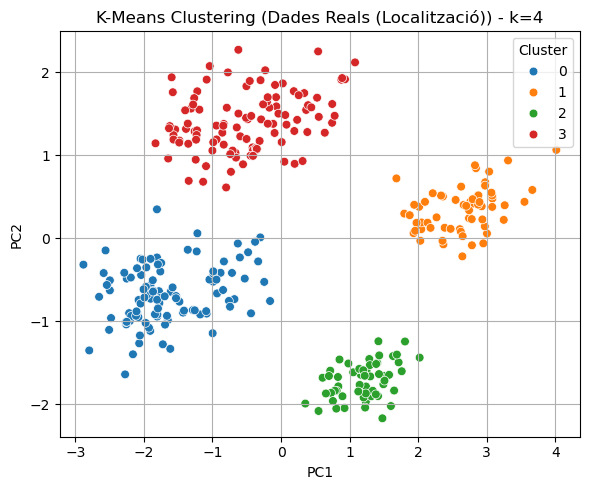

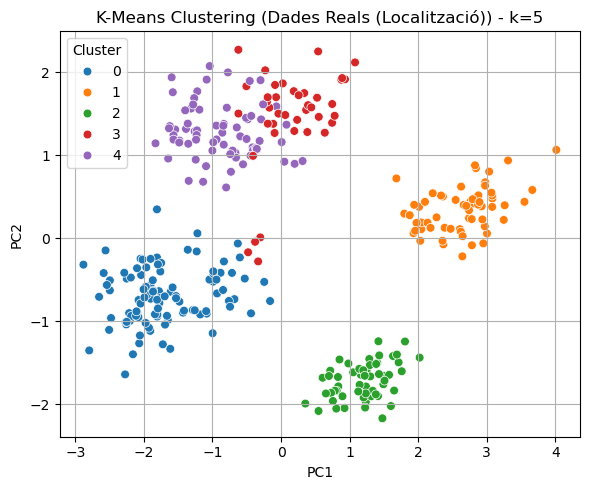

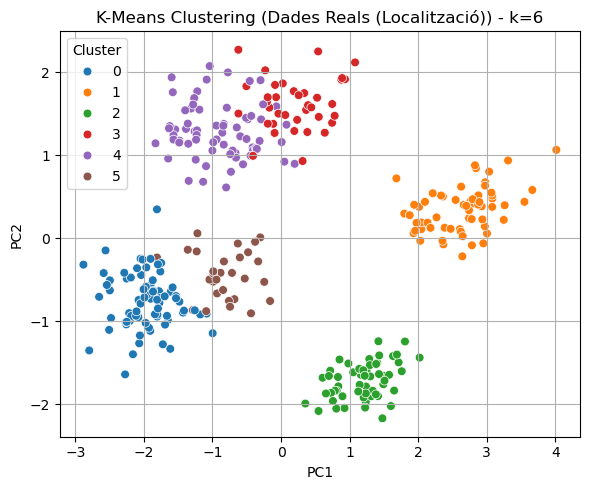

In [12]:
kmean_clustering_and_plot(X_real_scaled, y_real_class, 'Dades Reals (Classe)', k_range=range(2, 7))
kmean_clustering_and_plot(X_real_scaled, y_real_location, 'Dades Reals (Localització)', k_range=range(2, 7))

#### Anàlisis Dades Reals

- **K-Means (k=2)**

Les dades es divideixen en dos grans clústers, un en la part esquerre i l'altre a la dreta.La separació entre aquests dos clústers és extremadament nítida, amb pràcticament cap solapament.

- **K-Means (k=3)**

S'observa que les 3 agrupacions corresponent gairebé perfectament a les 3 classes reals del dataset. K-means ha aconseguit una separació gairebé perfecta dels tres clústers, que pràcticament coincideixen amb les classes originals. Però s'observa una mínima barreja entre el clúster 0 i el clúster 2 a la part central-esquerra.

- **K-Means (k=4)**

Comença a subdividir una o més de les classes reals existents per crea un clúster addicional. La regió de la dreta i la inferior-esquerra es mantenen com a clústers cohesius, mentre que la regió superior-esquerra, que correspon a la classe C1/L2 original, es divideix en 3 o 4 sub-clústers.

- **K-Means (k=5 i k = 6)**

Encara que es creen més grups, aquests ja no corresponen a les classes original del dataset, sinó a subdivisions dins de les classes. 


En conclusió, l'algorisme k-means funciona de manera excel·lent en el dataset real, trobant agrupacions de manera nítida quan k=3. Aquesta claredat en els clústers és un fort indicador de la bona estructura i separabilitat del dataset.

### AHC

L'Agrupament Jeràrquic Aglomeratiu (AHC) és una tècnica d'aprenentatge no supervisat que construeix una jerarquia de clústers. No requereix especificar el nombre de clústers i produeix una representació en forma de dendrograma.

Les 2 estratègies d'enllaç que es consideren són:
- **UPGMA (Unweighted Pair Group Method Arithmetic Mean)**: Distància mitjana entre tots els punts dels dos clústers.
- **Complete Linkage**: Màxima distància entre punts dels dos clústers.

In [13]:
def plot_dendrogram(X_scaled, y, title, method='average'):
    # Calcular distàncies euclidianes
    distance_matrix = pdist(X_scaled, metric='euclidean')

    # Calcular linkage
    Z = linkage(distance_matrix, method=method)

    # Fer el dendrograma
    plt.figure(figsize=(14, 6))
    dendro = dendrogram(Z, labels=np.arange(len(y)), leaf_rotation=90, leaf_font_size=8)

    # Obtenir l'ordre de les fulles per pintar els punts sota
    leaf_order = dendro['leaves']
    labels = np.array(y)
    cmap = plt.colormaps['tab10']
    unique_classes = np.unique(labels)

    # Crear mapeig de classe → índex per colors
    class_to_index = {cls: i for i, cls in enumerate(unique_classes)}

    # Afegir punts de color sota el dendrograma
    for i, idx in enumerate(leaf_order):
        cls = labels[idx]
        color = cmap(class_to_index[cls] % 10)
        plt.plot(i, -2, 'o', color=color, markersize=6)

    # Llegenda
    for cls, i in class_to_index.items():
        plt.plot([], [], 'o', color=cmap(i % 10), label=f'Classe {cls}')
    plt.legend(loc='upper right')

    plt.title(f'Dendrograma ({method.capitalize()} linkage) - {title}')
    plt.xlabel('Patrons')
    plt.ylabel('Distància Euclidiana')
    plt.tight_layout()
    plt.show()


#### Dades sintètiques

Es mostra el dendrograma resultant per cada mètode. A sota del dendrograma, s'afegeixen punts de colors que indiquen la **classe real** de cada patró.

Es permet analitzar:
- Estructura jeràrquica de les dades
- Coherència entre els clústers i les etiquetes reals.

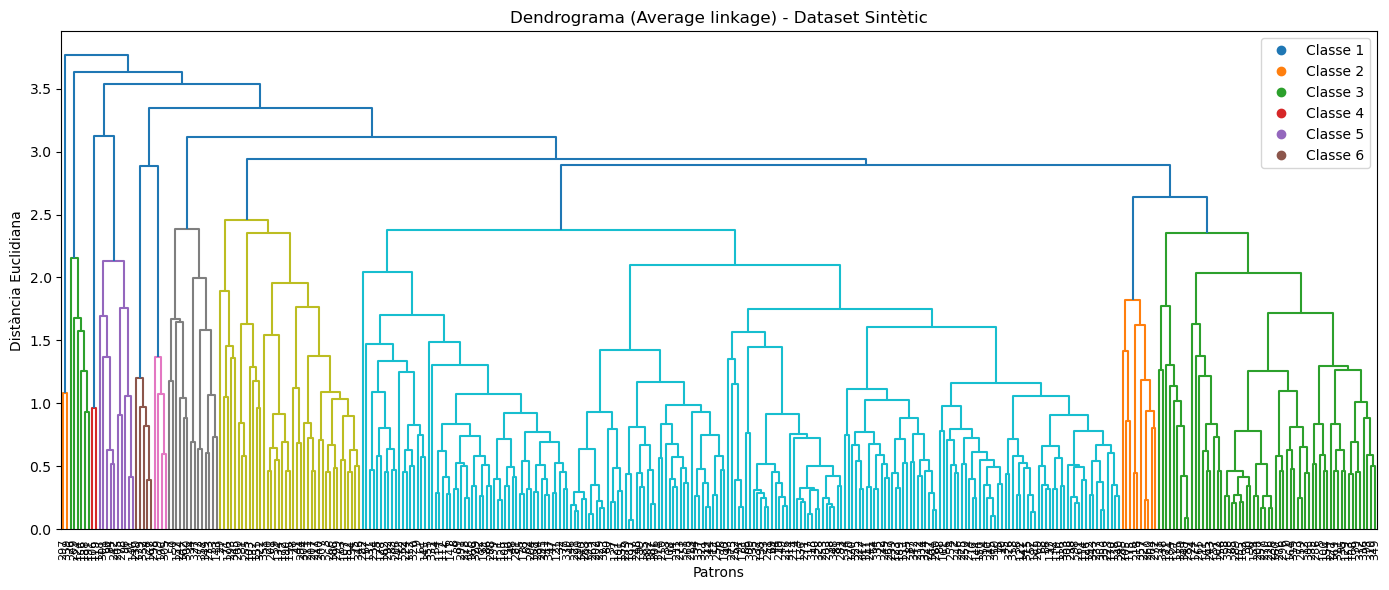

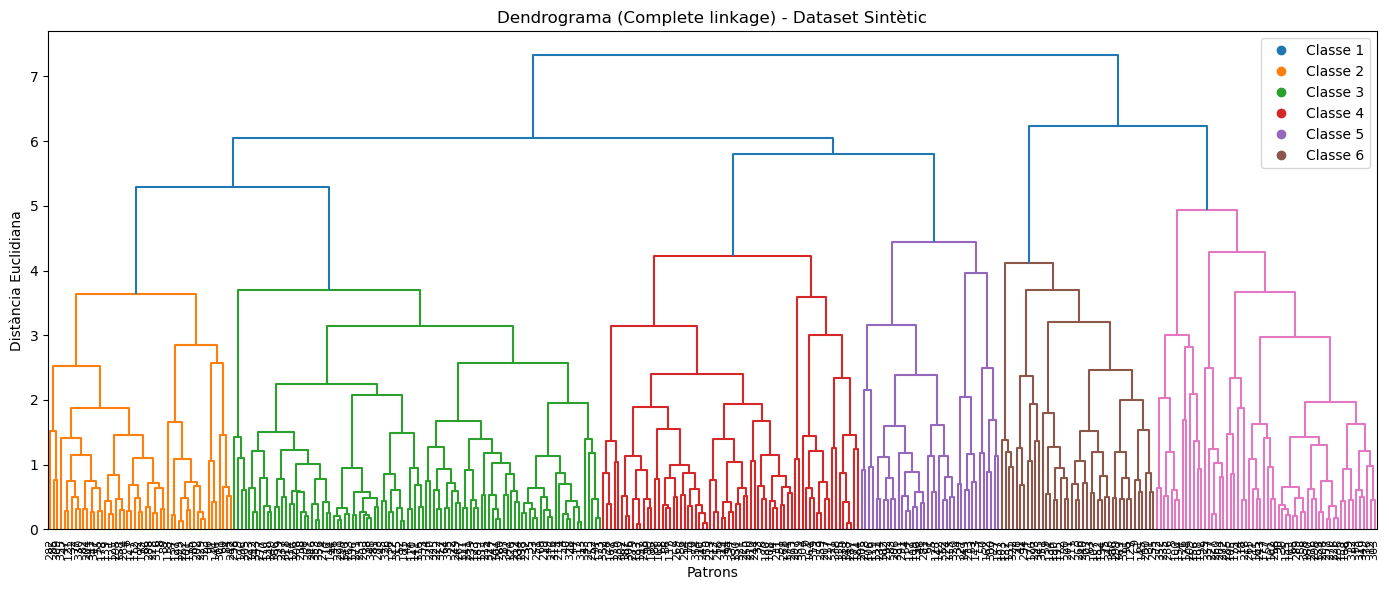

In [14]:
plot_dendrogram(X_synthetic_scaled, y_synthetic_class, "Dataset Sintètic", method='average')  # UPGMA
plot_dendrogram(X_synthetic_scaled, y_synthetic_class, "Dataset Sintètic", method='complete')  # CL

#### Anàlisis Dataset Sintètic

Un dendrograma és un arbre de clústers. L'eix X mostra les observacions individuals o els clústers en un moment donar, i l'eix Y representa la distància o dissimilaritat entre els clústers que es fusionen. 

El mètode d'enllaç `average` calcula la distància mitjana entre tots els parells de punts en els dos clústers que es volen fusionar. I el `complete` calcula la distància entre dos clústers com la distància màxima entre qualsevol parell d'observacions.

1. **Dendrograma Average linkage**

El dendrograma mostra una clara estructura jeràrquica on els punts individuals s'agrupen progressivament en clústers més grans. L'eix Y representa la distància Euclidiana a la qual els clústers es fusionen.

Tallant a una distància de 3, podríem obtenir 2 o 3 clústers grans, on un podria ser la Classe 3, i els altres una barreja de les altre classes. I tallant a una distància més baixa, podríem identificar més clúster, però amb una barreja de colors considerable.

S'observa que algunes classes estan més separades que d'altres a distàncies més baixes i que hi ha dispersió intraclasse, presència de colors barrejats en els braços del dendrograma a distàncies baixes. Aixì indica que hi ha barreja de classes reals.

2. **Dendrograma Complete linkage**

El rang de l'eix Y és més gran que amb Average linkage. Això es perquè és més sensible als outliers i tendeix a formar clústers més compactes, però els fusiona a distàncies més grans.

La separació de classes és més evident amb distàncies altes, ja que s'observen formacions de clústers més compactes on els braços tendeixen a ser més alts abans de fusionar-se.

En conclusió, l'AHC proporciona una visió jeràrquica de les agrupacions en el dataset sintètic. Confirma que algunes classes són més fàcils de separar, mentre que d'altres estan molt barrejades, el que dificulta la formació de clústers purs. 

#### Dades reals

Es mostra el dendrograma resultant per cada mètode. A sota del dendrograma, s'afegeixen punts de colors que indiquen la **classe real** i la **localització** de cada patró.

Es permet analitzar:
- Estructura jeràrquica de les dades
- Coherència entre els clústers i les etiquetes reals.

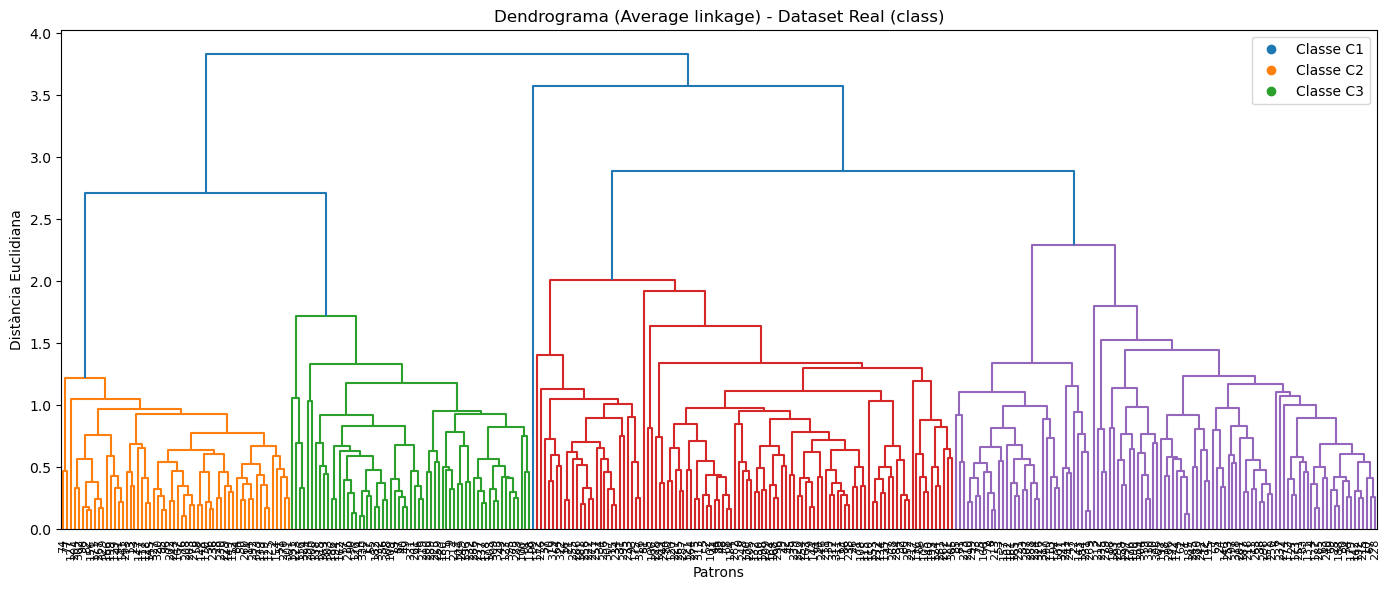

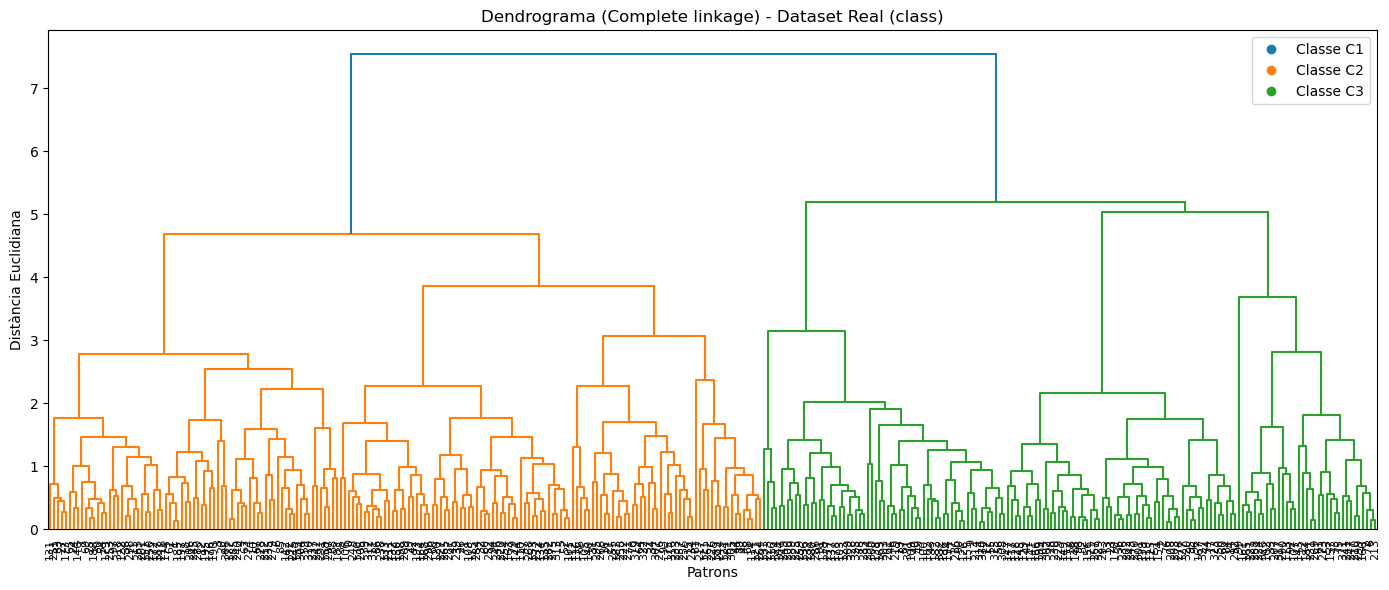

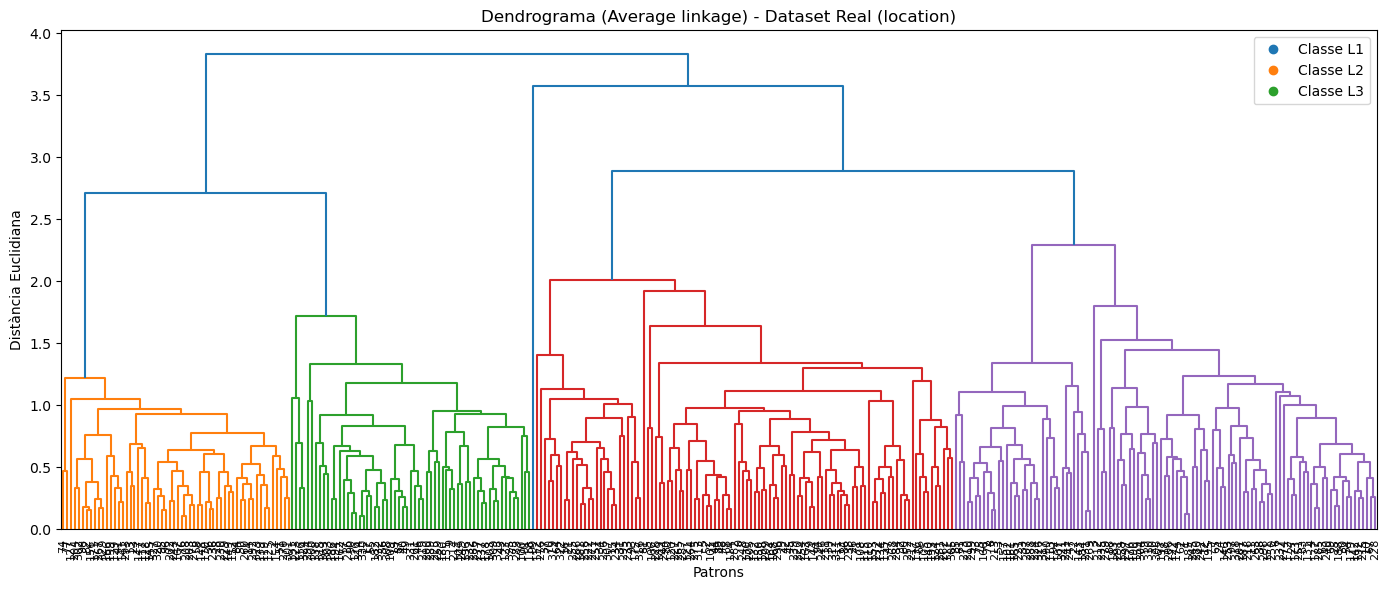

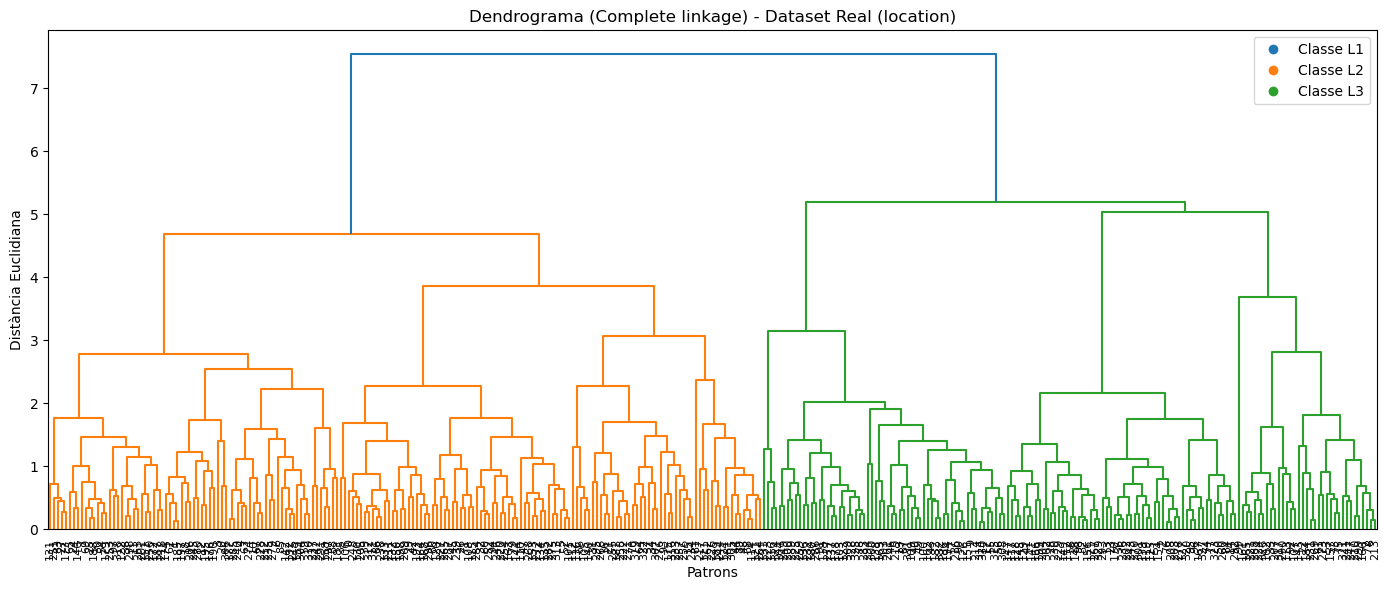

In [15]:
plot_dendrogram(X_real_scaled, y_real_class, "Dataset Real (class)", method='average')  # UPGMA
plot_dendrogram(X_real_scaled, y_real_class, "Dataset Real (class)", method='complete')

plot_dendrogram(X_real_scaled, y_real_location, "Dataset Real (location)", method='average')  # UPGMA
plot_dendrogram(X_real_scaled, y_real_location, "Dataset Real (location)", method='complete')

#### Anàlisis Dades Reals

1. **Dendrograma Average Linkage per Classe i Localització**

El dendrograma mostra una excel·lent separació de les classes. Es poden observar tres grans ramificacions principals que es fusionen a distàncies relativament altes. La classe 1 forma una agrupació a l'esquerra, la Classe 2 a la part central i la Classe 3 a la dreta. 

A una distància de 2 obtindríem 3 clústers que serien gairebé completament purs en termes de la seva classe real. Hi ha molt poca barreja de colors dins les ramificacions, cosa que indica que els punt de cada classe són molt propers.

2. **Dendrograma Complete Linkage per Classe i Localització**

La separació de clústers és altament efectiva, els clústers resultatnt són purs en termes de les classes reals. Les branques són molt altes abans de fusionar-se indicant que les distàncies entre les classes són grans. 

En conclusió, l'AHC funciona de manera excepcionalment bé en el dataset real aconseguint identificar i separar les 3 classes reals de manera casi perfecte.

### Autoencoder

Els **autoencoders** són xarxes neuronals no supervisades que s'entrenen per reproduir les dades d'entrada a la sortida. Es componen de:

- **Encoder**: Redueix les dades a una representació de menor dimensió.
- **Decoder**: Reconstrueix les dades a partir de la codificació.

En aquest cas, entrenem un autoencoder per **reduir les dades a 2 dimensions**

**Arquitectura utilitzada**

L'arquitectura de l'autoencoder implementat és la següent:

- **Entrada**: Nombre de característiques originals.
- **Capa oculta**: 8 neurones, activació ReLU.
- **Bottleneck (codificació)**: 2 neurones, activació lineal (sortida 2D).
- **Capa Oculta (decoder)**: 8 neurones, activació ReLU.
- **Sortida**: reconstrucció amb activació lineal.

**Paràmetres d'entrenament**

- **Optimitzador**: `Adam` amb taxa d'aprenentatge 0.01
- **Funció de pèrdua**: MSE (Mean Squared Error)
- **Nombre d'epochs**: 50
- **Mida del batch**: 32
- Entrenament amb `shuffle=True` per garantir millor mescla de les mostres.

In [16]:
def autoencoder_projection(X, y, title, epochs=50, batch_size=32):
    input_dim = X.shape[1]
    encoding_dim = 2  # Per a projecció 2D

    # Arquitectura simple
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(8, activation='relu')(input_layer)
    bottleneck = Dense(encoding_dim, activation='linear')(encoded)
    decoded = Dense(8, activation='relu')(bottleneck)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, output_layer)
    encoder = Model(input_layer, bottleneck)

    autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

    X_encoded = encoder.predict(X)

    labels = np.array(y)
    unique_classes = np.unique(labels)
    cmap = plt.colormaps['tab10']

    plt.figure(figsize=(6, 5))
    for i, cls in enumerate(unique_classes):
        idx = labels == cls
        plt.scatter(X_encoded[idx, 0], X_encoded[idx, 1], color=cmap(i % 10), label=f'Classe {cls}', alpha=0.7)
    plt.title(f'Autoencoder 2D - {title}')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Dades sintètiques

Un cop entrenat l'autoencoder, extraiem la codificació 2D i representem les dades en un diagrama de dispersió 2D, fent servir un colo diferent per a cada classe.

2025-05-30 15:18:42.109981: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


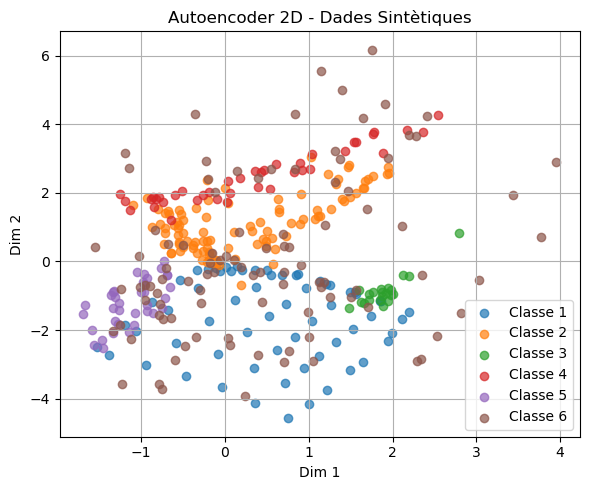

In [17]:
autoencoder_projection(X_synthetic_scaled, y_synthetic_class, "Dades Sintètiques")

#### Anàlisis del Dataset Sintètic

L'autoencoder ha aconseguit una millor separació de certes classes en comparació amb la projecció PCA del dataset sintètic, especialment per les Classes 3, 4 i 5 que formen agrupacions més cohesionades. No obstant la superposició continua sent un repte.En comparació amb la tècnica t-SNE no aconsegueix el mateix nivell de compressió i aïllament de clústers per aquest dataset.

En resum, l'Autoencoder és una tècnica prometedora per a la reducció de dimensionalitat. En el cas del dataset sintètic, ha aconseguit agrupar millor algunes classes que PCA, però no ha superat la claredat de t-SNE per a la visualització de totes les classes.

#### Dades reals

Un cop entrenat l'autoencoder, extraiem la codificació 2D i representem les dades en un diagrama de dispersió 2D, fent servir un color diferent per a cada classe i localització.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


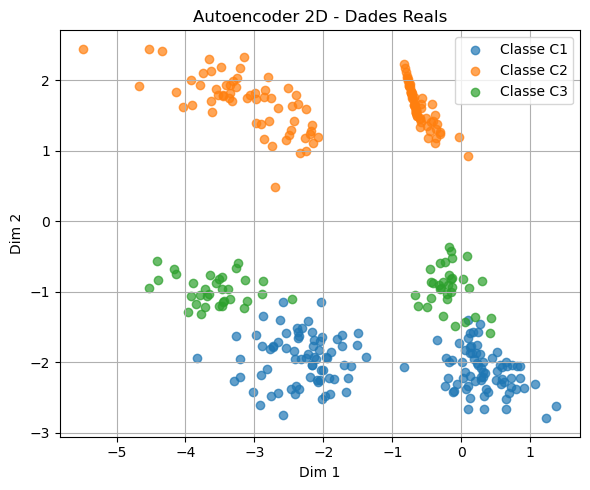

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


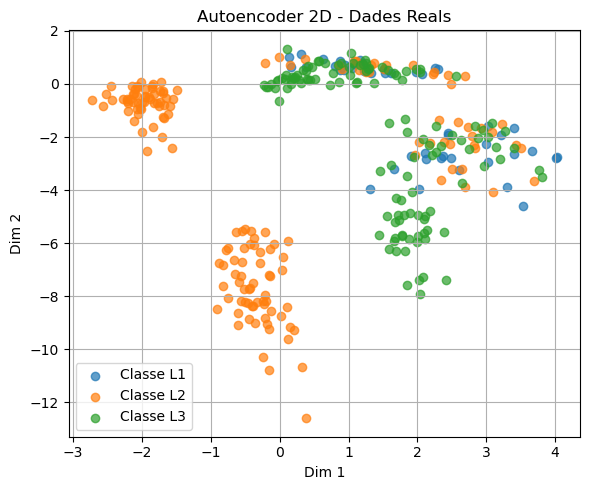

In [18]:
autoencoder_projection(X_real_scaled, y_real_class, "Dades Reals")
autoencoder_projection(X_real_scaled, y_real_location, "Dades Reals")

#### Anàlisis del Dataset real

S'observa una separació excel·lent de la Classe 2 (taronja) on forma un clúster molt compacte i separat a la part superior central. També es veu un solapament entre les classes 1 i 3 i alguna punts atípics. Això suggereix que l'autoencoder ha après una projecció no lineal, cosa que és característica d'aquest tipus de models.

També es veu una confirmació de la correlació entre Classe i Localització que confirma que el model d'autoencoder projecte les dades basant-se en les seves característiques intrínsiques i que les classes i localitzacions estan correlacionades.

En conclusió, s'aconsegueix una excel·lent separació per a les classes 2 i 3, i suggereix que tot i ser una eina potent, la capacitat d'un autoencoder pot variar i no sempre superarà altres mètodes dependents de les característiques del dataset i de l'arquitectura específica del autoencoder.

### SOM

Els **Self Organizing Maps (SOM)** són una tècnica no supervisada de reducció i visualització de dimensionalitat basada en xarxes neuronals competitives. Organitzen les dades en una graella bidimensional (mapa), mantenint relacions topològiques entre les mostres.

**Paràmetres**
- **Mida del mapa**: 10x10 (100 neurones)
- **Funció de veïnatge**: `gaussian`
- **Nombre d'iteracions**: 1000
- **Sigma**: 1.0
- **Taxa d'aprenentatge**: 0.5
- **Inicialització aleatòria amb seed 42**

Les visualitzacions són les següents:

1. **Heatmap de la classe dominant**: Cada neurona mostra la classe més freqüent entre les mostres que s'hi han assignat. Això permet veure la distribució espacial de les classes.
2. **U-Matrix (Unified Distance Matrix)**: Representa les distàncies entre les neurones veïnes. Valors alts (tons clars) indiquen fronteres entre grups.
3. **Component Planes**: Visualitzen, per cada atribut, com varia el seu valor sobre el mapa. Útil per saber quins atributs influeixen més en la formació de grups.

In [19]:
def som_visualization(X, y, title, som_x=10, som_y=10):
    # Convertim les etiquetes a enters si no ho són
    if not np.issubdtype(type(y[0]), np.integer):
        classes = sorted(list(set(y)))
        class_to_int = {cls: i for i, cls in enumerate(classes)}
        y_int = [class_to_int[label] for label in y]
    else:
        y_int = y

    som = MiniSom(som_x, som_y, X.shape[1], sigma=1.0, learning_rate=0.5, 
                neighborhood_function='gaussian', random_seed=42)
    som.train(X, 1000, verbose=False)

    labels_map = {}
    for i, x in enumerate(X):
        winner = som.winner(x)
        label = y_int[i]
        if winner not in labels_map:
            labels_map[winner] = []
        labels_map[winner].append(label)

    heatmap = np.zeros((som_x, som_y))
    for (i, j), labels in labels_map.items():
        heatmap[i, j] = np.bincount(labels).argmax()

    plt.figure(figsize=(8, 6))
    plt.imshow(heatmap.T, origin='lower')
    plt.colorbar(label='Classe més freqüent')
    plt.title(f'Heatmap SOM - {title}')
    plt.tight_layout()
    plt.show()

    # U-Matrix
    plt.figure(figsize=(8, 6))
    plt.title(f'U-Matrix - {title}')
    umatrix = som.distance_map().T
    plt.imshow(umatrix, origin='lower', cmap='bone')
    plt.colorbar(label='Distància entre neurones')
    plt.tight_layout()
    plt.show()

    # Component planes
    for i in range(X.shape[1]):
        plt.figure(figsize=(6, 5))
        plt.title(f'Component Plane - {title} - Atribut: {i}')
        plane = som.get_weights()[:, :, i].T
        plt.imshow(plane, origin='lower', cmap='coolwarm')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

#### Dades sintètiques

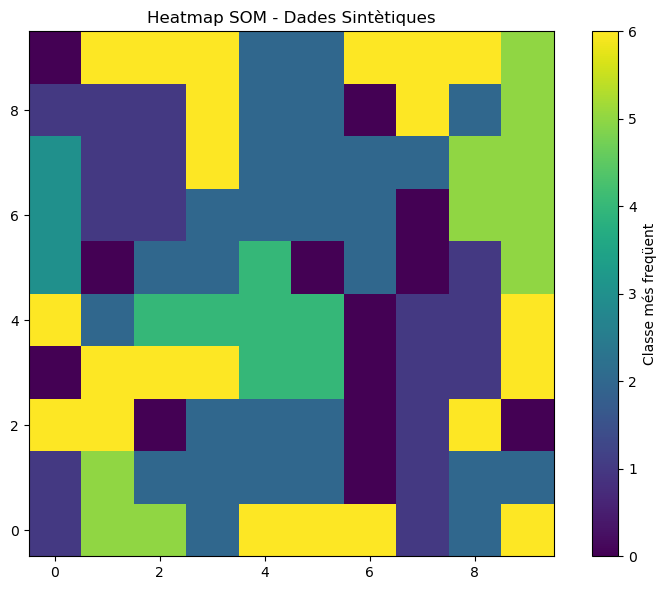

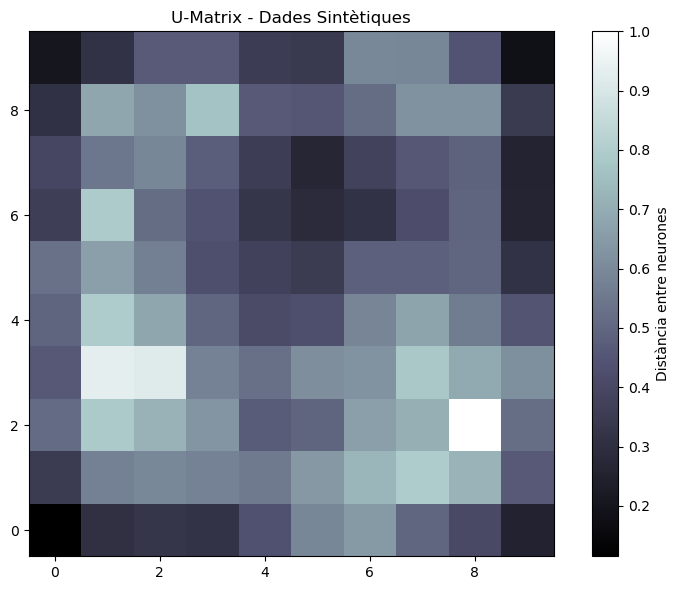

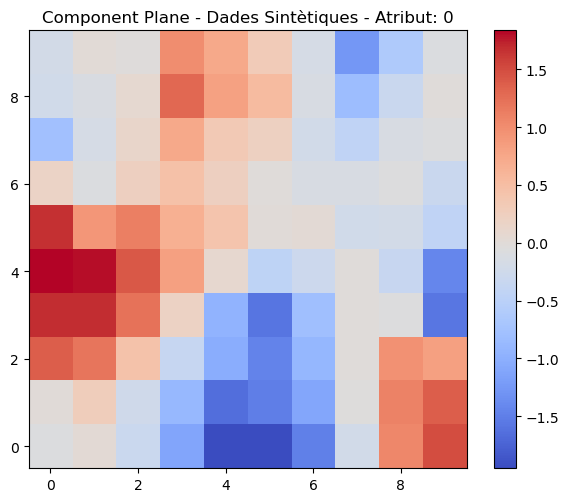

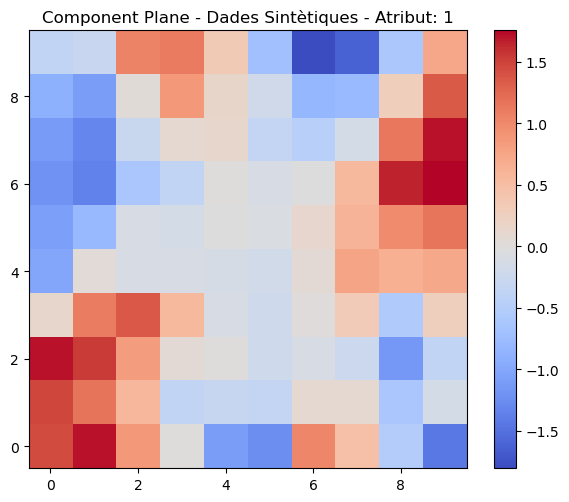

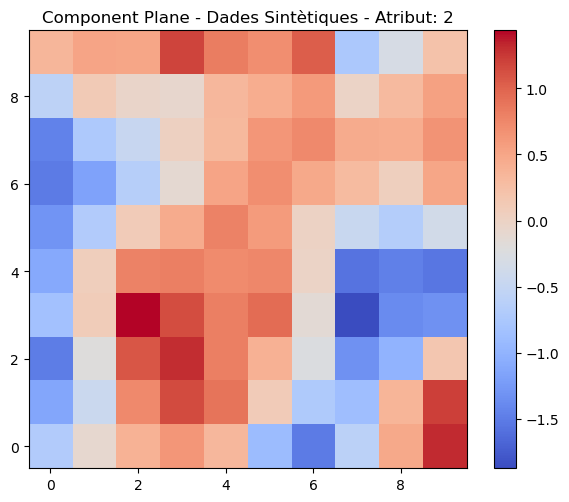

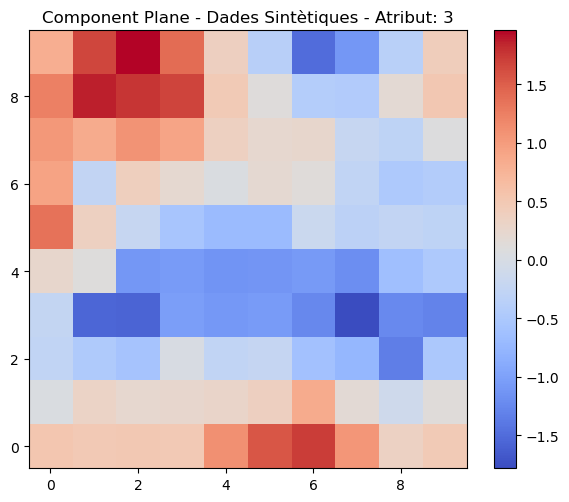

In [20]:
som_visualization(X_synthetic_scaled, y_synthetic_class, 'Dades Sintètiques')

#### Anàlisis de Dades Sintètiques

1. **Heatmap SOM**

En aquest mapa de calor cada cel·la de la quadrícula representa una neurona del SOM. El color de cada cel·la indica la classe més freqüent (de 0 a 6) que s'ha assignat a aquesta neurona.

S'observa que algunes classes formen regions contigües al mapa. Per exemple, hi ha grans regions de color groc i blau fosc/verd fosc. També s'observa solapament i barreja indicant que la xarxa no ha pogut separar perfectament totes les classes. 

2. **U-Matrix**

Aquí cada cel·la del mapa representa una neurona, i el color d'una cel·la indica la distància mitjana entre la neurona actual i les seves veïnes. Els colors clars representen distàncies grans i els colors foscos representen petites distàncies.

S'observa que hi ha diverses regions fosques, que suggereixen la presència de clústers. Veiem regions clares que actuen com a "murs" que separen aquestes regions fosques, indicant la presència de límits entre els clústers.

3. **Component Plane**

Aquí es mostren el "plans de components" per als atributs 1, 2 i 3. Cada gràfica mostra el valor d'un atribut específic per a cada neurona. Els colors indiquen els valors de l'atribut: blau representa valors baixos, vermell alts.

- **Atribut 1**: Mostra un patró amb valors alts a les cantonades inferiors i superiors-dreta, i valors baixos a la part esquerra i superior-dreta.
- **Atribut 2**: Distribució diferent, amb valors alts concentrats en la part superior i inferiors dreta, i valors baixos a la part central-inferior i esquerra.
- **Atribut 3**: Destaca per tenir una gran regió central amb valors baixos, i valors alts a les parts superiors i inferiors esquerra i dreta.

En resum, el SOM és una eina valuosa per visualitzar i analitzar clústers en dades complexes. Es reflecteix la barreja de colors en diverses regions del mapa, confirmant la complexitat del dataset sintètic.

#### Dades Reals

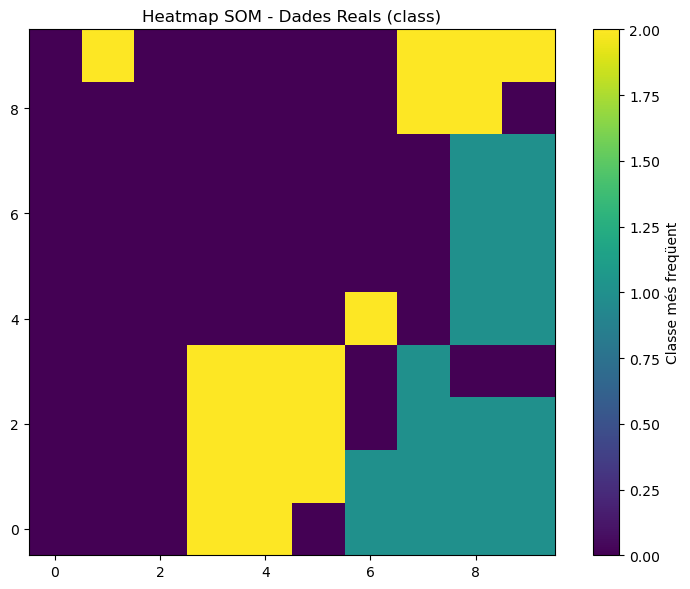

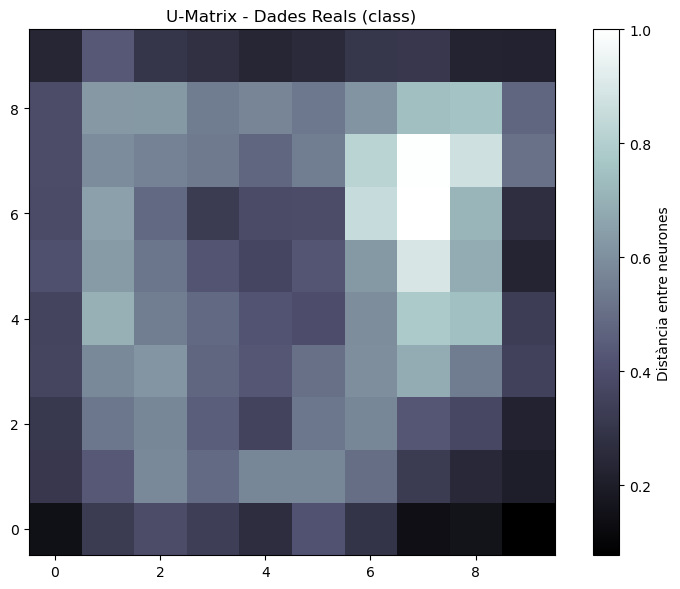

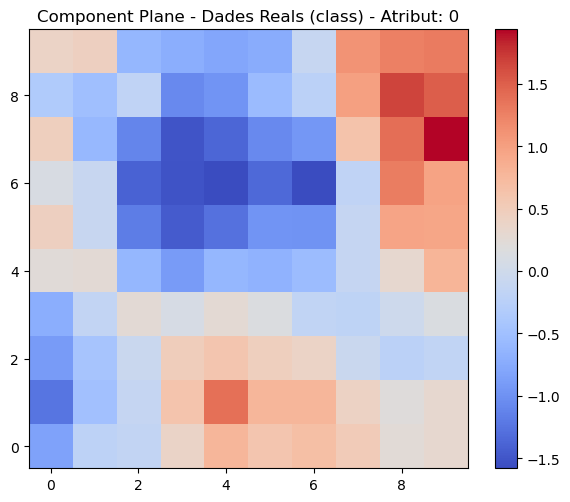

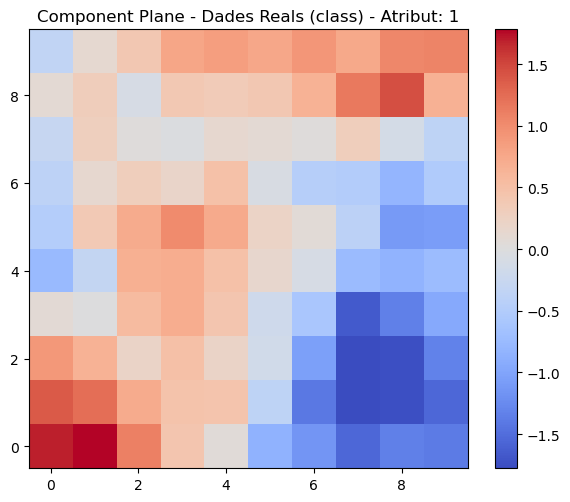

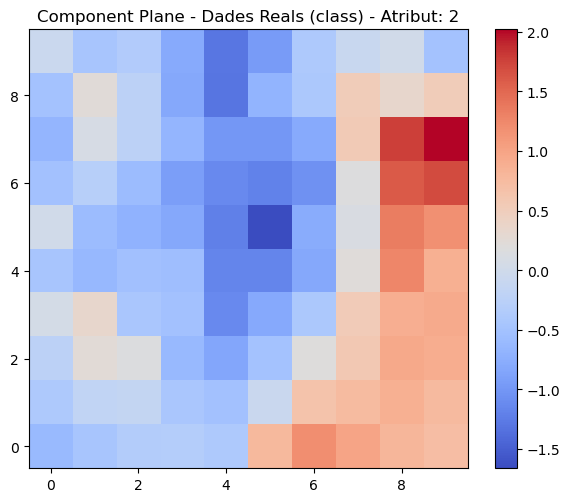

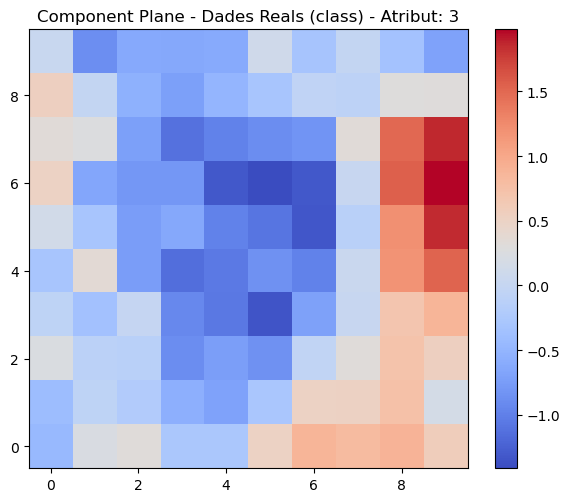

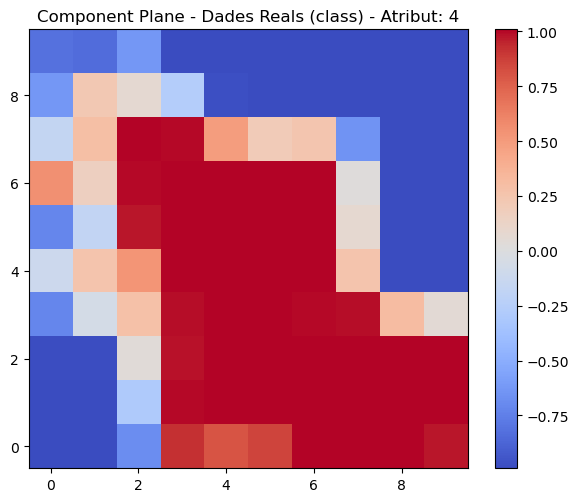

In [21]:
som_visualization(X_real_scaled, y_real_class, 'Dades Reals (class)')

#### Anàlisis Dataset Real

1. **Heatmap SOM**

A diferència del dataset sintètic, aquí podem observar una separació de classes molt clara. Hi ha una gran regió a la part esquerra i superior-esquerra de color morat fosc, una de color verd a la part dreta superior-dreta i una altre groga en el centre i inferior-dreta. Les regions són molt homogènies en color, osigui que la majoria de punts s'assignen a una neurona de color morat fosc, per exemple. 

2. **U-Matrix**

Aquí s'observa clarament les fronteres entre els clústers. Es pot observar una regió molt clara/blanca que s'estén desde la part superior-dreta cap a la part central-inferior, i una altre clara a la part inferior-esquerra. Les regions fosques corresponen als clústers validant l'excel·lent separació observada en el mapa de calor.

3. **Component Plane**

- **Atribut 0**: Mostra una regió blava al centre esquerre i regions vermelles a les cantonades. Sembla discriminar les classes del centre de les de les vores.
- **Atribut 1**: S'observa una regió de valors baixos a la part inferior-dreta del mapa, la resta mostra valors mitjans. Sembla ser un bon discriminador per la regió inferior-dreta.
- **Atribut 2**: El patró és força similar al de l'atribut 0. Es veu una regió de valors baixos al centre-esquerre i regions de valors alts a les cantonades. Això pot ser que l'atribut 2 tingui correlació amb l'atribut 0.
- **Atribut 3**: Valors baixos que ocupen la major part de la meitat superior del mapa i els valors alts es concentren a la part inferior-dreta. Fort descriptor per la divisió entre 2 grans regions.
- **Atribut 4**: Atribut notablement diferent on s'observa que els valors baixos estàn a la part superior-esquerra i inferior-esquerra, cap a valors alts a la part central-superior-dreta i inferior-dreta. Això indica que és un atribut discriminatori important.

En conclusió, s'observa una excel·lent separació de clústers en el mapa de calor i la U-Matrix. I gràcies als pans de components podem veure que els atributs 3 i 4 són més informatius.

## 4. Comparació de Resultats en les diferents tècniques

1. **Dataset Sintètic**

El dataset sintètic es caracteritza per tenir un nombre conegut de classes, però amb un solapament significatiu i una estructura no lineal complexa que dificulta la seva separació.

- **PCA**: Limitat. Les 2 primers components només expliquen el 55% de la variància. Perd informació important i és la tècnica que menys ha aconseguit discriminar les classes visualment.
  
- **t-SNE**: Amb una perplexitat adequada de 30, ha aconseguit una separació visual clara i nítida de la majoria de classes. Computacionalment és més costosa que el PCA i és sensible al paràmetre `perplexity`, però és la tècnique més efectiva per veure l'estructura dels clústers.

- **k-means**: Rendiment pobre per qualsevol k provada, els clúster presentaven solapament significatiu amb les classes reals. Va confirmar la dificultat d'agrupar linealment aquest dataset amb les seves 6 classes originals.

- **AHC**:  El dendrograma mostra com s'agrupen jeràrquicament en funció de la seva semblança. El average linkage mostra barreges de colors i solapament. El complete linkage genera clúster més compacte però que es fusionen a distàncies més altes. Mostra limitacions dels mètodes d'agrupament quan les classes no són ben separables.

- **Autoencoder**: Millora respecta a PCA en la separació visual. Va aconseguir una separació millor de la Clase 5 i 6, gràcies a la seva capacitat d'apendre transformacions no lineals. Requereix entrenament (cost computacional) i la qualitat depèn de l'arquitectura. Encara així, ha demostrat ser superior al PCA i igualar al t-SNE.

- **SOM**: El heatmap va mostrar que algunes classes formaven regions, però amb solapament notable. És sensible a la inicialització i la grandària del mapa però ofereix una visió topològica útils i la capacitat d'analitzar la influència dels atributs.


2. **Dataset Sintètic**

- **PCA**: Excel·lent. Les 2 primeres components expliquen el 85% de la variància, mostrant una separació molt clara de les classes. Altament efectiu i eficient.
  
- **t-SNE**: Excepcional. Amb una perplexitat adequada (30 o 50) s'aconsegueix una separació casi perfecta, formant clúster compactes i diferenciats.

- **k-means**: Rendiment excel·lent. Amb k=3 s'aconsegueis una partició casi perfecta, molt eficaç quan els clúster són esfèrics i ben separats. Demostra que és el més adequat per a aquest dataset.

- **AHC**:  Els dendrogrmes mostren una separació nítida de 3 clústers que corresponen perfectament amb les classes originals. Computacionalment és més costós per a grans datasets. 

- **Autoencoder**: Alt potencial per separa classes com la 2 i la 3, però la seva efectivitat depèn de l'arquitectura utilitzada. No sempre garanteix els millors resultats.

- **SOM**: Rendiment excel·lent. Separació clara i homogènia de les 3 classes. I els plan de components defineixen les característiques clau dels altributs per definir cada clúster. Útil per fer un anàlisis detallat de l'estructura del dataset i les propietats dels clústers.

En conclusió, aquests anàlisis han demostrat que no existeix una tècnica única que sigui la "millor" per a tots els escenaris. La tria de la tècnica depèn de les característiques del dataset (linealitat, solapament, dimensionalitat) i de l'objectiu de l'anàlisis (visualització, clustering...). Per a dades complexes, les tècniques no lineals són crucial. Per a dades ben separades moltes tècniques poden funcionar de manera excel·lent.
